In [1]:
import ujson as json
import calendar
import datetime, time
import time as t
import scipy
import numpy as np
start=t.time()
filename='Cedar_Valley.json'
with open(filename, 'r') as f:
    points = json.load(f)
print len(points['features'])

177


2.34670090675
Well  373233113110501
['374248113075201' '374550113040601' '373319113120301' '373542113122401'
 '373742113100801' 'linear']
[ 0.96599187  0.95318119  0.93496266  0.87292251  0.86925763]
1978-08-31 00:00:00


/home/student/tethys/miniconda/envs/tethys/lib/python2.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/student/tethys/miniconda/envs/tethys/lib/python2.7/site-packages/ipykernel_launcher.py:93: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/student/tethys/miniconda/envs/tethys/lib/python2.7/site-packages/ipykernel_launcher.py:100: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/student/tethys/miniconda/envs/tethys/lib/python2.7/site-packages/ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/student/tethys/miniconda/envs/tethys/lib/python2.7/site-pack

Well  373236113111401
['373233113110501' '374122113063801' '374450113053201' '374550113040601'
 '374744113055001' 'linear']
[ 0.83619758  0.82718104  0.81038421  0.80735994  0.75309722]
1977-08-31 00:00:00
Well  373319113120301
['373509113101101' '375004112562401' '374458113021001' '373742113100801'
 '373542113122401' 'linear']
[ 0.99290895  0.98902152  0.98780335  0.98371378  0.98206641]
1978-08-31 00:00:00
Well  373509113101101
['374338113035400' '373542113122401' '373319113120301' '373742113100801'
 '374554113020801' 'linear']
[ 0.99964796  0.99488872  0.99290895  0.98479042  0.98223049]
1978-08-31 00:00:00
Well  373542113122401
['373509113101101' '375004112562401' '373319113120301' '374458113021001'
 '374554113020801' 'linear']
[ 0.99488872  0.99023383  0.98206641  0.96914967  0.96743237]
1978-08-31 00:00:00
Well  373742113100801
['373509113101101' '374554113020801' '373319113120301' '374458113021001'
 '375004112562401' 'linear']
[ 0.98479042  0.98413683  0.98371378  0.96778233  0.

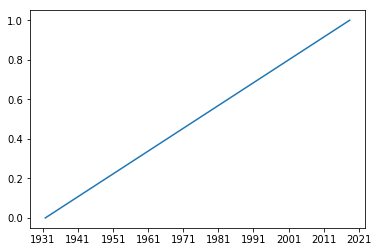

finished
30.1145501137


In [2]:
start_date=1980
end_date=2010
interval=5
resolution=.01
time_tolerance=5
min_ratio=1
min_samples=5
iterations=int((end_date-start_date)/interval+1)

from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
pd.options.display.max_rows=1000
pp = PdfPages('multipage.pdf')
firststart=t.time()
interpolation_df=pd.DataFrame()
combined_df = pd.DataFrame()
for well in points['features']:
    if 'TsTime' in well:
        if np.array(well['TsTime']).max()>calendar.timegm(datetime.datetime(end_date, 1, 1).timetuple()) and np.array(well['TsTime']).min()<calendar.timegm(datetime.datetime(start_date+10, 1, 1).timetuple()):
            if np.array(well['TsTime']).max()>calendar.timegm(datetime.datetime(end_date, 1, 1).timetuple()) and np.array(well['TsTime']).min()<calendar.timegm(datetime.datetime(start_date, 1, 1).timetuple()):
                name = str(well['properties']['HydroID'])
            else:
                name = str(well['properties']['HydroID']) + 'Short'
            wells_df = pd.DataFrame(index=pd.to_datetime(well['TsTime'], unit='s', origin='unix'), data=well['TsValue'], columns=[name])
            wells_df.index.drop_duplicates(keep="first")
            wells_df = wells_df.resample('3M').mean()

            combined_df = pd.concat([combined_df, wells_df], join="outer", axis=1)
            combined_df.drop_duplicates(inplace=True)
#combined_df is a pandas dataframe containing the ts depth to water table values for each well in the aquifer with the min number of points
# The columns of combined_df are the HydroIDs of the wells. If the well timeseries data spans the period of interpolation, the column title
# is the HydroID. If the timeseries does not span the time period, then the column title is the HydroID + "Short"
# The rows of the database are the timeseries values for 3 month intervals from start_date to end_date
corrs_df = combined_df.interpolate(method='pchip', limit_area='inside', limit=8)
combined_df.interpolate(method='pchip', inplace=True, limit_area='inside')
combined_df=combined_df.resample('3M').nearest()
interpolation_df = combined_df.drop(combined_df.filter(regex='Short').columns, axis=1)
combined_df['linear']=np.linspace(0,1,len(combined_df))
corr_df=corrs_df.corr(min_periods=12)#12
corr_df=corr_df-np.identity(len(corr_df))
length=len(corr_df)-1
for row in corr_df.index:
    if 'Short' in str(row):
        corr_df=corr_df.drop(row)
print t.time()-firststart

well_list=[]
for i in range(length):#length
    reflist=np.array(corr_df.nlargest(5,corr_df.columns[i]).index)
    welli = corr_df.columns[i]
    well_list.append(welli)
#     if 'Short' not in str(welli):
    mydf = combined_df[[welli]].copy()
    print "Well ",welli
    corr_values=corr_df.nlargest(5, corr_df.columns[i]).values[:,i]
    reflist=np.append(reflist,'linear')
    print reflist
    print corr_values
    delete_list=[]
    for j in range(len(corr_values)):
        if corr_values[j]<=0.5:
            delete_list.append(j)
    if len(delete_list)>0:
        reflist=np.delete(reflist,delete_list)
    if len(reflist)>=1:
        for ref in reflist:
            mydf=pd.concat([mydf,combined_df[ref]], axis=1)
        norm_exdf=mydf.dropna(how="any", subset=reflist)
        normz_exdf=norm_exdf.copy()
        smaller_exdf=normz_exdf.copy()
        smaller_exdf=smaller_exdf.dropna(how="any")
        for column in norm_exdf.columns[0:]:
            normz_exdf[column]=(norm_exdf[column]-smaller_exdf[column].min())/(smaller_exdf[column].max()-smaller_exdf[column].min())
        exdf = normz_exdf.copy()
        mymin=max(exdf[welli].first_valid_index(),exdf[reflist[0]].first_valid_index())
        print mymin
        mymax="1995-01-01 00:00:00"#exdf[welli].last_valid_index()-pd.DateOffset(years=25)#(exdf[welli].last_valid_index()-mymin)/4
        exdf=exdf[mymin:mymax]
        y=exdf[welli]
        x=exdf.as_matrix(columns=reflist)
        n,m=x.shape
        x0=np.ones((n,1))
        x=np.hstack((x,x0))
        model=sm.OLS(y,x)
        model_fit = model.fit_regularized(alpha=0.005)
        b=np.array(model_fit.params)
        
        linx=exdf.as_matrix(columns=['linear'])
        n,m=x.shape
        x0=np.ones((n,1))
        linx=np.hstack((linx,x0))
        linmodel=sm.OLS(y,linx)
        linmodel_fit = linmodel.fit_regularized(alpha=0)
        linb=np.array(linmodel_fit.params)
        linA=normz_exdf.as_matrix(columns=['linear'])
        n,m=linA.shape
        A0=np.ones((n,1))
        linA=np.hstack((linA,A0))
        norm_exdf['linprediction']=np.dot(linA,linb)
        norm_exdf['linprediction']=norm_exdf['linprediction']*(norm_exdf[welli].max()-norm_exdf[welli].min())+norm_exdf[welli].min()
        
        A=normz_exdf.as_matrix(columns=reflist)
        n,m=A.shape
        A0=np.ones((n,1))
        A=np.hstack((A,A0))
        norm_exdf['prediction']=np.dot(A,b)
        norm_exdf['prediction']=norm_exdf['prediction']*(norm_exdf[welli].max()-norm_exdf[welli].min())+norm_exdf[welli].min()
        #toggle this next line of code
#         norm_exdf.loc[corrs_df[welli].notnull(),'prediction']=corrs_df[welli]
        newname=str(welli).replace('Short','')
        interpolation_df = pd.concat([interpolation_df, norm_exdf['prediction']], join="outer", axis=1)
        interpolation_df=interpolation_df.rename(columns={"prediction":newname})
        plt.plot(combined_df[welli], 'r', label='Testing Data')
        plt.plot(norm_exdf['prediction'], 'r--', label='MLR Prediction')
        plt.plot(combined_df[welli][mymin:mymax], 'g', label='Training Data')
        combined_df[welli+'naive']=combined_df[welli]
        combined_df[welli+'naive'][mymax:]=combined_df[welli+'naive'][combined_df.index.get_loc(mymax,method='nearest')]
        plt.plot(combined_df[welli+'naive']['1995':],'b--',label='Naive')
        plt.plot(norm_exdf['linprediction'],'y--',label='Least Squares')
        if "Short" in welli:
            well_title="Well "+welli[:-5]
        else:
            well_title="Well "+welli
        plt.title(well_title)
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel('Depth to GW (ft)')
        pp.savefig()
        plt.close()
        combined_df[welli+'lin']=norm_exdf['linprediction']
        combined_df[welli+'prediction']=norm_exdf['prediction']
        if welli=="374210113044801Short":
            print norm_exdf['prediction']['1985':'2015']
pp.close()
plt.plot(combined_df['linear'])
plt.show()
print "finished"
print t.time()-firststart

In [3]:
import HydroErr as he
# training_set=combined_df.loc[train_df.index]
testing_set=combined_df['1995':]

# well_list.remove('374927113033401')
# well_list.remove('373233113110501Short')
# well_list.remove('374555113062701Short')

tr_errors=[]
te_errors=[]
tl_errors=[]
for well in well_list:
    prediction=str(well)+"prediction"
    naive=str(well)+"naive"
    lin=str(well)+"lin"
    d=he.rmse(testing_set[prediction],testing_set[well])
    d2=he.rmse(testing_set[naive],testing_set[well])
    d3=he.rmse(testing_set[lin],testing_set[well])
    tr_errors.append(d)
    te_errors.append(d2)
    tl_errors.append(d3)
errors=np.column_stack((tr_errors,te_errors,tl_errors))
error_df=pd.DataFrame(index=well_list,columns=['prediction','naive','lin'],data=errors)
print(error_df)


                      prediction      naive        lin
373233113110501         3.862709   3.925915   4.953854
373236113111401         5.665238   9.626041   9.892531
373319113120301         1.387797  19.281342  17.997047
373509113101101         2.326462  36.643461  41.000093
373542113122401         5.293930  34.575153  23.452387
373742113100801         4.363534  28.705401  42.627384
374105113085001        24.565199  26.287838  37.092571
374122113063801         5.314613  10.920973   8.098968
374132113063601        10.328709  21.156993  32.585434
374248113075201        11.353263  13.143884   8.944665
374304113052901        10.060099  19.369790  29.381883
374321113044301         2.324826   0.925357   0.890744
374338113035400         6.385859  28.771691  19.385298
374345113032301         6.523693  18.035343  13.406209
374423113053301        11.328949  17.432184  45.875555
374423113053401         4.976885  15.787502  29.459269
374450113053201         6.500851   6.032434   7.739070
3744581130

/home/student/tethys/miniconda/envs/tethys/lib/python2.7/site-packages/HydroErr/HydroErr.py:6250: UserWarning: Row(s) [89 90 91 92 93] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  UserWarning)
/home/student/tethys/miniconda/envs/tethys/lib/python2.7/site-packages/HydroErr/HydroErr.py:6250: UserWarning: Row(s) [93] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  UserWarning)
/home/student/tethys/miniconda/envs/tethys/lib/python2.7/site-packages/HydroErr/HydroErr.py:6250: UserWarning: Row(s) [89 90 91 92 93] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  UserWarning)
/home/student/tethys/miniconda/envs/tethys/lib/python2.7/site-packages/HydroErr/HydroErr.py:6250: UserWarning: Row(s) [76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  UserWarning)
/home/student/tethys/miniconda/envs/tethys/lib/python2.7/

In [4]:
newinterpolation_df=interpolation_df[str(start_date):str(end_date)].resample('5Y',closed='left').nearest()
corrs_df=corrs_df[str(start_date):str(end_date)].resample('5Y',closed='left').nearest()
corrs_df.rename(columns=lambda x: x.replace('Short',''),inplace=True)
lons=[]
lats=[]
values=[]
elevations=[]
ids=[]
mylon=[]
mylat=[]
myelevs=[]
myids=[]
for wellid in newinterpolation_df.columns:
    for well in points['features']:
        if wellid==str(well['properties']['HydroID']):
            mylon.append(well['geometry']['coordinates'][0])
            mylat.append(well['geometry']['coordinates'][1])
            myelevs.append(well['properties']['LandElev'])
            myids.append(wellid)
            newinterpolation_df.loc[corrs_df[wellid].notnull(),wellid]=corrs_df[wellid]
            break
for i in range(iterations):
    myvalue=np.array(newinterpolation_df.iloc[i].tolist())
    myelev=np.add(np.array(myelevs),myvalue)
    lons.append(mylon)
    lats.append(mylat)
    values.append(myvalue)
    elevations.append(myelev)  
    ids.append(myids)
    print len(mylon)
lons = np.array(lons)
lats = np.array(lats)
ids=np.array(ids)
values = np.array(values)
elevations = np.array(elevations)
print "done"

59
59
59
59
59
59
59
done


59


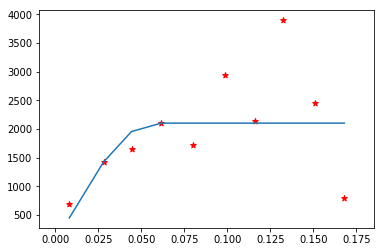

sill, range, nugget
[  2.10131893e+03   5.71179204e-02   1.00000000e+00]
59


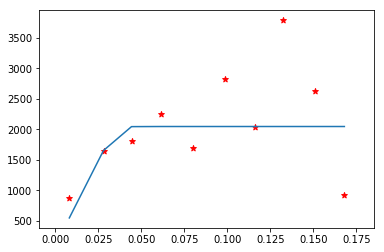

sill, range, nugget
[  2.04584721e+03   4.54513234e-02   1.00000000e+00]
59


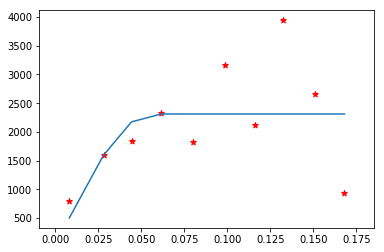

sill, range, nugget
[  2.31103541e+03   5.58073577e-02   1.00000000e+00]
59


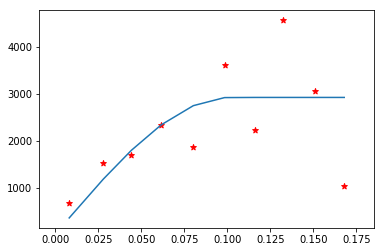

sill, range, nugget
[  2.91742131e+03   1.01303587e-01   9.99859679e-01]
59


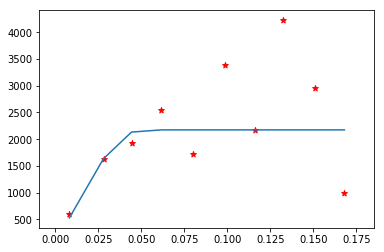

sill, range, nugget
[  2.17263534e+03   5.00117832e-02   1.00000000e+00]
59


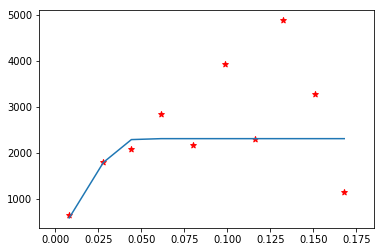

sill, range, nugget
[  2.30393367e+03   4.80282910e-02   1.00000000e+00]
59


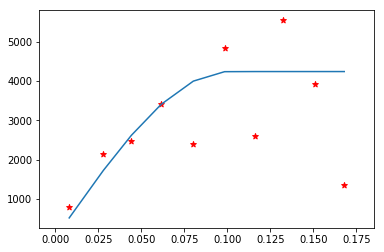

sill, range, nugget
[  4.24257722e+03   1.00699162e-01   9.99982928e-01]
[array([  2.10131893e+03,   5.71179204e-02,   1.00000000e+00]), array([  2.04584721e+03,   4.54513234e-02,   1.00000000e+00]), array([  2.31103541e+03,   5.58073577e-02,   1.00000000e+00]), array([  2.91742131e+03,   1.01303587e-01,   9.99859679e-01]), array([  2.17263534e+03,   5.00117832e-02,   1.00000000e+00]), array([  2.30393367e+03,   4.80282910e-02,   1.00000000e+00]), array([  4.24257722e+03,   1.00699162e-01,   9.99982928e-01])]


In [36]:
from scipy.optimize import least_squares
def great_circle_distance(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance between one or multiple pairs of
    points given in spherical coordinates. Spherical coordinates are expected
    in degrees. Angle definition follows standard longitude/latitude definition.
    This uses the arctan version of the great-circle distance function
    (en.wikipedia.org/wiki/Great-circle_distance) for increased
    numerical stability.
    Parameters
    ----------
    lon1: float scalar or numpy array
        Longitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lat1: float scalar or numpy array
        Latitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lon2: float scalar or numpy array
        Longitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    lat2: float scalar or numpy array
        Latitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    Calculation of distances follows numpy elementwise semantics, so if
    an array of length N is passed, all input parameters need to be
    arrays of length N or scalars.
    Returns
    -------
    distance: float scalar or numpy array
        The great circle distance(s) (in degrees) between the
        given pair(s) of points.
    """
    # Convert to radians:
    lat1 = np.array(lat1)*np.pi/180.0
    lat2 = np.array(lat2)*np.pi/180.0
    dlon = (lon1-lon2)*np.pi/180.0

    # Evaluate trigonometric functions that need to be evaluated more
    # than once:
    c1 = np.cos(lat1)
    s1 = np.sin(lat1)
    c2 = np.cos(lat2)
    s2 = np.sin(lat2)
    cd = np.cos(dlon)

    # This uses the arctan version of the great-circle distance function
    # from en.wikipedia.org/wiki/Great-circle_distance for increased
    # numerical stability.
    # Formula can be obtained from [2] combining eqns. (14)-(16)
    # for spherical geometry (f=0).

    return 180.0 / np.pi * np.arctan2(np.sqrt((c2*np.sin(dlon))**2 + (c1*s2-s1*c2*cd)**2), s1*s2+c1*c2*cd)


def _variogram_residuals(params, x, y, variogram_function, weight):
    """Function used in variogram model estimation. Returns residuals between
    calculated variogram and actual data (lags/semivariance).
    Called by _calculate_variogram_model.
    Parameters
    ----------
    params: list or 1D array
        parameters for calculating the model variogram
    x: ndarray
        lags (distances) at which to evaluate the model variogram
    y: ndarray
        experimental semivariances at the specified lags
    variogram_function: callable
        the actual funtion that evaluates the model variogram
    weight: bool
        flag for implementing the crude weighting routine, used in order to
        fit smaller lags better
    Returns
    -------
    resid: 1d array
        residuals, dimension same as y
    """

    # this crude weighting routine can be used to better fit the model
    # variogram to the experimental variogram at smaller lags...
    # the weights are calculated from a logistic function, so weights at small
    # lags are ~1 and weights at the longest lags are ~0;
    # the center of the logistic weighting is hard-coded to be at 70% of the
    # distance from the shortest lag to the largest lag
    if weight:
        drange = np.amax(x) - np.amin(x)
        k = 2.1972 / (0.1 * drange)
        x0 = 0.7 * drange + np.amin(x)
        weights = 1. / (1. + np.exp(-k * (x0 - x)))
        weights /= np.sum(weights)
        resid = (variogram_function(params, x) - y) * weights
    else:
        resid = variogram_function(params, x) - y

    return resid

def gaussian_variogram_model(m, d):
    """Gaussian model, m is [psill, range, nugget]"""
    psill = float(m[0])
    range_ = float(m[1])
    nugget = float(m[2])
    return psill * (1. - np.exp(-d**2./(range_*4./7.)**2.)) + nugget
def spherical_variogram_model(m, d):
    """Spherical model, m is [psill, range, nugget]"""
    psill = float(m[0])
    range_ = float(m[1])
    nugget = float(m[2])
    return np.piecewise(d, [d <= range_, d > range_],
                        [lambda x: psill * ((3.*x)/(2.*range_) - (x**3.)/(2.*range_**3.)) + nugget, psill + nugget])


'''The generate_variogram function automatically fits a variogram to the data
    Inputs:
        X: a 2d array of geographical coordinates of sample points (longitude, latitude) of length n
        y: an array of length n containing the values at sample points, ordered the same as X
        variogram_function: a function for the variogram model (Spherical, Gaussian)
    Returns:
        variogram_model_parameters: a list of 1. the sill, 2. the range, 3. the nugget'''


def generate_variogram(X, y, variogram_function):
    # This calculates the pairwise geographic distance and variance between pairs of points
    x1, x2 = np.meshgrid(X[:, 0], X[:, 0], sparse=True)
    y1, y2 = np.meshgrid(X[:, 1], X[:, 1], sparse=True)
    z1, z2 = np.meshgrid(y, y, sparse=True)
    d = great_circle_distance(x1, y1, x2, y2)
    g = 0.5 * (z1 - z2) ** 2.
    indices = np.indices(d.shape)
    d = d[(indices[0, :, :] > indices[1, :, :])]
    g = g[(indices[0, :, :] > indices[1, :, :])]
    # d=squareform(pdist(X,metric='euclidean'))
    # g = 0.5 * pdist(y[:, None], metric='sqeuclidean')
    # print(d)

    # Now we will sort the d and g into bins
    nlags = 10
    weight = False
    dmax = np.amin(d) + (np.amax(d) - np.amin(d)) / 2.0
    # dmax = np.amax(d)

    dmin = np.amin(d)
    dd = (dmax - dmin) / nlags
    bins = [dmin + n * dd for n in range(nlags)]
    dmax += 0.001
    bins.append(dmax)

    lags = np.zeros(nlags)
    semivariance = np.zeros(nlags)

    for n in range(nlags):
        # This 'if... else...' statement ensures that there are data
        # in the bin so that numpy can actually find the mean. If we
        # don't test this first, then Python kicks out an annoying warning
        # message when there is an empty bin and we try to calculate the mean.
        if d[(d >= bins[n]) & (d < bins[n + 1])].size > 0:
            lags[n] = np.mean(d[(d >= bins[n]) & (d < bins[n + 1])])
            semivariance[n] = np.mean(g[(d >= bins[n]) & (d < bins[n + 1])])
        else:
            lags[n] = np.nan
            semivariance[n] = np.nan
    lags = lags[~np.isnan(semivariance)]
    semivariance = semivariance[~np.isnan(semivariance)]
    # First entry is the sill, then the range, then the nugget
    if len(lags) > 3:
        x0 = [np.amax(semivariance) - np.amin(semivariance), lags[2], 0]
        bnds = ([0., lags[2], 0.], [10. * np.amax(semivariance), np.amax(lags), 1])
    elif len(lags) > 1:
        x0 = [np.amax(semivariance) - np.amin(semivariance), lags[0], 0]
        bnds = ([0., lags[0], 0.], [10. * np.amax(semivariance), np.amax(lags), 1])
    else:
        x0 = [0, 0, 0]
        bnds = ([0., 0, 0.], [1000, 10, 1])

    # use 'soft' L1-norm minimization in order to buffer against
    # potential outliers (weird/skewed points)
    res = least_squares(_variogram_residuals, x0, bounds=bnds, loss='soft_l1',
                        args=(lags, semivariance, variogram_function, True))
    variogram_model_parameters = res.x
    semvars=spherical_variogram_model(variogram_model_parameters, lags)
    plt.scatter(lags,semivariance,marker='*',color="red")
    plt.plot(lags,semvars)
    plt.show()
    print("sill, range, nugget")
    print(variogram_model_parameters)
    return variogram_model_parameters

coordinates = []
all_empty = True
for i in range(0, iterations):
    coordinate = np.array((lons[i], lats[i])).T
    coordinates.append(coordinate)
    if len(coordinate) > 1:
        all_empty = False
if all_empty == True:
    message = "There is not enough data to perform interpolation"
    print(message)
coordinates = np.array(coordinates)
variogram_function = spherical_variogram_model
variogram_model_parameters = []
for i in range(0, iterations):
    print(len(coordinates[i]))
    if len(coordinates[i]) > 2:
        X = coordinates[i]
        y=values[i]
        variogram_model_parameters.append(generate_variogram(X, y, variogram_function))
    else:
        variogram_model_parameters.append([0, 0, 0])
print(variogram_model_parameters)

In [ ]:
lonmin=360.0
latmin=90.0
lonmax=-360.0
latmax=-90.0
for i in points['features']:
    if i['geometry']['coordinates'][0]<lonmin:
        lonmin=i['geometry']['coordinates'][0]
    if i['geometry']['coordinates'][0]>lonmax:
        lonmax=i['geometry']['coordinates'][0]
    if i['geometry']['coordinates'][1]<latmin:
        latmin=i['geometry']['coordinates'][1]
    if i['geometry']['coordinates'][1]>latmax:
        latmax=i['geometry']['coordinates'][1]
lonmin=round(lonmin-.05,1)
latmin=round(latmin-.05,1)
lonmax=round(lonmax+.05,1)
latmax=round(latmax+.05,1)
print lonmin,lonmax,latmin,latmax
print len(points['features'])

In [ ]:
import numpy as np
latgrid = np.mgrid[latmin:latmax:resolution]
longrid = np.mgrid[lonmin:lonmax:resolution]
latrange=len(latgrid)
lonrange=len(longrid)
print latrange, lonrange


In [ ]:
import pygslib
outx=np.repeat(longrid,latrange)
outy=np.tile(latgrid,lonrange)
grids=[]
for i in range(0,iterations):
    sill = variogram_model_parameters[i][0]
    vrange = variogram_model_parameters[i][1]
    params={
        'x':lons[i],
        'y':lats[i],
        'vr':values[i],
        'nx':lonrange,
        'ny':latrange,
        'nz':1,
        'xmn':lonmin,
        'ymn':latmin,
        'zmn':0,
        'xsiz':resolution,
        'ysiz':resolution,
        'zsiz':1,
        'nxdis':1,
        'nydis':1,
        'nzdis':1,
        'outx':outx,
        'outy':outy,
        'radius':2,
        'radius1':2,
        'radius2':2,
        'ndmax':15,
        'ndmin':5,
        'noct':0,
        'ktype':1,
        'idbg':0,
        'c0':0,
        'it':1,
        'cc':sill,
        'aa':vrange,
        'aa1':vrange,
        'aa2':vrange
    }
    estimate= pygslib.gslib.kt3d(params)
    print i
    array=estimate[0]['outidpower']#outest
    array2=estimate[0]['outidpower']
    grid=np.reshape(array,(lonrange,latrange))
    grid2=np.reshape(array2,(lonrange,latrange))
    x=np.isnan(grid)
    grid[x]=grid2[x]
    grids.append(grid)
grids=np.array(grids)

In [ ]:
with open('UtahMajorAquifers.json','r') as f:
    allwells = ''
    wells = f.readlines()
    for i in range(0, len(wells)):
        allwells += wells[i]
utah=json.loads(allwells)


AquiferShape= {
    'type':'FeatureCollection',
    'features':[]
}
print utah['features'][0].viewkeys()
for i in utah['features']:
    if i['properties']['Full_Name']=="Cedar Valley":#Full_Name #AQ_NAME TRINITY
        AquiferShape['features'].append(i)

with open('shapefile.json','w') as outfile:
    json.dump(AquiferShape, outfile)
    

In [ ]:
from __future__ import division
import netCDF4
from netCDF4 import Dataset
import numpy as np
import os
import time as t
from scipy import interpolate
from sklearn.utils import resample
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
import numpy as np
import matplotlib.pyplot as plt
import cython
hydros= np.array(ids[0])
volunit="Acre-ft"

interpolation_type="Kriging"

latlen=len(latgrid)
lonlen=len(longrid)
filename='testinterpolate2.nc'
h=netCDF4.Dataset(filename,'w',format="NETCDF4")
h.interpolation="Kriging Multi Linear"
h.start_date=start_date
h.end_date=end_date
h.interval=interval
h.resolution=resolution
h.min_samples=min_samples
h.min_ratio=min_ratio
h.time_tolerance=time_tolerance
h.default=0
h.units='English'


time = h.createDimension("time", 0)
lat = h.createDimension("lat", latlen)
lon = h.createDimension("lon", lonlen)
hydroid=h.createDimension("hydroid", len(ids[0]))
latitude=h.createVariable("lat",np.float64,("lat"))
longitude=h.createVariable("lon",np.float64,("lon"))
time=h.createVariable("time",np.float64,("time"), fill_value="NaN")
hydroids=h.createVariable("hydroid",str,("hydroid"), fill_value="NaN")
hydroids.axis="H"

tsvalue=h.createVariable("tsvalue",np.float64,('time','hydroid'),fill_value=-9999)
tsvalue.units="ft"
tsvalue.coordinates="time hydroid"

depth=h.createVariable("depth",np.float64,('time','lon','lat'),fill_value=-999)
depth.long_name="Depth to Groundwater"
depth.units="ft"
depth.grid_mapping="WGS84"
depth.cell_measures="area: area"
depth.coordinates="time lat lon"

elevation=h.createVariable("elevation",np.float64,('time','lon','lat'),fill_value=-999)
elevation.long_name="Elevation of Groundwater"
elevation.units="ft"
elevation.grid_mapping="WGS84"
elevation.cell_measures="area: area"
elevation.coordinates="time lat lon"

drawdown=h.createVariable("drawdown",np.float64,('time','lon','lat'),fill_value=-999)
drawdown.long_name="Well Drawdown"
drawdown.units="ft"
drawdown.grid_mapping="WGS84"
drawdown.cell_measures="area: area"
drawdown.coordinates="time lat lon"

volume = h.createVariable("volume", np.float64, ('time', 'lon', 'lat'), fill_value=-9999)
volume.long_name = "Change in aquifer storage volume since " + str(start_date)
volume.units = volunit
volume.grid_mapping = "WGS84"
volume.cell_measures = "area: area"
volume.coordinates = "time lat lon"

latitude.long_name="Latitude"
latitude.units="degrees_north"
latitude.axis="Y"
longitude.long_name="Longitude"
longitude.units="degrees_east"
longitude.axis="X"
time.axis="T"
time.units='days since 0001-01-01 00:00:00 UTC'
latitude[:]=latgrid[:]
longitude[:]=longrid[:]
hydroids[:]=ids[0,:]
year=start_date
timearray=[]
            
for i in range(0,iterations):
    print i
    timearray.append(datetime.datetime(year, 1, 1).toordinal() - 1)
    year += interval
    time[i] = timearray[i]
    tsvalue[i,:]=values[i,:]
    for x in range(0,lonrange):
            depth[i,x,:]=grids[i,x,:]
            elevation[i,x,:]=grids[i,x,:]
            if i==0:
                drawdown[i,x,:]=0
            else:
                drawdown[i,x,:]=depth[i,x,:]-depth[0,x,:]

h.close()
os.system("./aquifersubset.sh %s" % (filename))
# serverpath="/home/student/tds/apache-tomcat-8.5.30/content/thredds/public/testdata/groundwater"
# destination= os.path.join(serverpath, filename)
# os.rename(filename, destination)
end=t.time()
print(end-start)

